In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


 - Min class count:  976
Loaded 20496 images
Dataset type test label type: species


 - Min class count:  976
Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 o7ee3ga8


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-o7ee3ga8:best, 314.57MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:9.2


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                                                              | 0/2934 [00:00<?, ?it/s]

  0%|                                                                                                                                                    | 1/2934 [00:07<5:59:17,  7.35s/it]

  0%|▎                                                                                                                                                     | 5/2934 [00:07<54:32,  1.12s/it]

  0%|▌                                                                                                                                                    | 10/2934 [00:07<22:19,  2.18it/s]

  1%|▊                                                                                                                                                    | 15/2934 [00:07<12:26,  3.91it/s]

  1%|█                                                                                                                                                    | 20/2934 [00:07<07:51,  6.18it/s]

  1%|█▎                                                                                                                                                   | 25/2934 [00:07<05:21,  9.05it/s]

  1%|█▌                                                                                                                                                   | 30/2934 [00:07<03:51, 12.54it/s]

  1%|█▊                                                                                                                                                   | 35/2934 [00:08<02:54, 16.61it/s]

  1%|██                                                                                                                                                   | 40/2934 [00:08<02:17, 21.07it/s]

  2%|██▎                                                                                                                                                  | 45/2934 [00:08<01:52, 25.69it/s]

  2%|██▌                                                                                                                                                  | 50/2934 [00:08<01:35, 30.14it/s]

  2%|██▊                                                                                                                                                  | 55/2934 [00:08<01:24, 34.25it/s]

  2%|███                                                                                                                                                  | 60/2934 [00:08<01:16, 37.80it/s]

  2%|███▎                                                                                                                                                 | 65/2934 [00:08<01:10, 40.73it/s]

  2%|███▌                                                                                                                                                 | 70/2934 [00:08<01:06, 43.05it/s]

  3%|███▊                                                                                                                                                 | 75/2934 [00:08<01:03, 44.81it/s]

  3%|████                                                                                                                                                 | 80/2934 [00:08<01:01, 46.15it/s]

  3%|████▎                                                                                                                                                | 85/2934 [00:09<01:00, 47.12it/s]

  3%|████▌                                                                                                                                                | 90/2934 [00:09<00:59, 47.84it/s]

  3%|████▊                                                                                                                                                | 95/2934 [00:09<00:58, 48.34it/s]

  3%|█████                                                                                                                                               | 100/2934 [00:09<00:58, 48.73it/s]

  4%|█████▎                                                                                                                                              | 105/2934 [00:09<00:57, 49.01it/s]

  4%|█████▌                                                                                                                                              | 110/2934 [00:09<00:57, 49.04it/s]

  4%|█████▊                                                                                                                                              | 115/2934 [00:09<00:57, 49.21it/s]

  4%|██████                                                                                                                                              | 120/2934 [00:09<00:57, 49.31it/s]

  4%|██████▎                                                                                                                                             | 125/2934 [00:09<00:56, 49.41it/s]

  4%|██████▌                                                                                                                                             | 130/2934 [00:10<00:56, 49.49it/s]

  5%|██████▊                                                                                                                                             | 135/2934 [00:10<00:56, 49.53it/s]

  5%|███████                                                                                                                                             | 140/2934 [00:10<00:56, 49.55it/s]

  5%|███████▎                                                                                                                                            | 145/2934 [00:10<00:56, 49.58it/s]

  5%|███████▌                                                                                                                                            | 150/2934 [00:10<00:56, 49.63it/s]

  5%|███████▊                                                                                                                                            | 155/2934 [00:10<00:56, 49.59it/s]

  5%|████████                                                                                                                                            | 160/2934 [00:10<00:55, 49.59it/s]

  6%|████████▎                                                                                                                                           | 165/2934 [00:10<00:56, 49.44it/s]

  6%|████████▌                                                                                                                                           | 170/2934 [00:10<00:55, 49.50it/s]

  6%|████████▊                                                                                                                                           | 175/2934 [00:10<00:55, 49.49it/s]

  6%|█████████                                                                                                                                           | 180/2934 [00:11<00:55, 49.52it/s]

  6%|█████████▎                                                                                                                                          | 185/2934 [00:11<00:55, 49.52it/s]

  6%|█████████▌                                                                                                                                          | 190/2934 [00:11<00:55, 49.55it/s]

  7%|█████████▊                                                                                                                                          | 195/2934 [00:11<00:55, 49.58it/s]

  7%|██████████                                                                                                                                          | 200/2934 [00:11<00:55, 49.57it/s]

  7%|██████████▎                                                                                                                                         | 205/2934 [00:11<00:55, 49.61it/s]

  7%|██████████▌                                                                                                                                         | 210/2934 [00:11<00:54, 49.59it/s]

  7%|██████████▊                                                                                                                                         | 215/2934 [00:11<00:54, 49.62it/s]

  7%|███████████                                                                                                                                         | 220/2934 [00:11<00:54, 49.60it/s]

  8%|███████████▎                                                                                                                                        | 225/2934 [00:11<00:54, 49.42it/s]

  8%|███████████▌                                                                                                                                        | 230/2934 [00:12<00:54, 49.45it/s]

  8%|███████████▊                                                                                                                                        | 235/2934 [00:12<00:54, 49.51it/s]

  8%|████████████                                                                                                                                        | 240/2934 [00:12<00:54, 49.54it/s]

  8%|████████████▎                                                                                                                                       | 245/2934 [00:12<00:54, 49.56it/s]

  9%|████████████▌                                                                                                                                       | 250/2934 [00:12<00:54, 49.55it/s]

  9%|████████████▊                                                                                                                                       | 255/2934 [00:12<00:54, 49.57it/s]

  9%|█████████████                                                                                                                                       | 260/2934 [00:12<00:53, 49.60it/s]

  9%|█████████████▎                                                                                                                                      | 265/2934 [00:12<00:53, 49.59it/s]

  9%|█████████████▌                                                                                                                                      | 270/2934 [00:12<00:53, 49.50it/s]

  9%|█████████████▊                                                                                                                                      | 275/2934 [00:12<00:53, 49.61it/s]

 10%|██████████████                                                                                                                                      | 280/2934 [00:13<00:53, 49.65it/s]

 10%|██████████████▍                                                                                                                                     | 285/2934 [00:13<00:53, 49.70it/s]

 10%|██████████████▋                                                                                                                                     | 290/2934 [00:13<00:53, 49.74it/s]

 10%|██████████████▉                                                                                                                                     | 295/2934 [00:13<00:53, 49.77it/s]

 10%|███████████████▏                                                                                                                                    | 300/2934 [00:13<00:52, 49.80it/s]

 10%|███████████████▍                                                                                                                                    | 305/2934 [00:13<00:52, 49.84it/s]

 11%|███████████████▋                                                                                                                                    | 310/2934 [00:13<00:52, 49.84it/s]

 11%|███████████████▉                                                                                                                                    | 315/2934 [00:13<00:52, 49.84it/s]

 11%|████████████████▏                                                                                                                                   | 320/2934 [00:13<00:52, 49.84it/s]

 11%|████████████████▍                                                                                                                                   | 325/2934 [00:13<00:52, 49.88it/s]

 11%|████████████████▋                                                                                                                                   | 330/2934 [00:14<00:52, 49.84it/s]

 11%|████████████████▉                                                                                                                                   | 335/2934 [00:14<00:52, 49.69it/s]

 12%|█████████████████▏                                                                                                                                  | 340/2934 [00:14<00:52, 49.74it/s]

 12%|█████████████████▍                                                                                                                                  | 345/2934 [00:14<00:52, 49.77it/s]

 12%|█████████████████▋                                                                                                                                  | 350/2934 [00:14<00:51, 49.79it/s]

 12%|█████████████████▉                                                                                                                                  | 355/2934 [00:14<00:51, 49.76it/s]

 12%|██████████████████▏                                                                                                                                 | 360/2934 [00:14<00:51, 49.77it/s]

 12%|██████████████████▍                                                                                                                                 | 365/2934 [00:14<00:51, 49.76it/s]

 13%|██████████████████▋                                                                                                                                 | 370/2934 [00:14<00:51, 49.77it/s]

 13%|██████████████████▉                                                                                                                                 | 375/2934 [00:14<00:51, 49.79it/s]

 13%|███████████████████▏                                                                                                                                | 380/2934 [00:15<00:51, 49.80it/s]

 13%|███████████████████▍                                                                                                                                | 385/2934 [00:15<00:51, 49.66it/s]

 13%|███████████████████▋                                                                                                                                | 390/2934 [00:15<00:51, 49.70it/s]

 13%|███████████████████▉                                                                                                                                | 395/2934 [00:15<00:51, 49.72it/s]

 14%|████████████████████▏                                                                                                                               | 400/2934 [00:15<00:50, 49.73it/s]

 14%|████████████████████▍                                                                                                                               | 405/2934 [00:15<00:50, 49.78it/s]

 14%|████████████████████▋                                                                                                                               | 410/2934 [00:15<00:50, 49.84it/s]

 14%|████████████████████▉                                                                                                                               | 415/2934 [00:15<00:50, 49.83it/s]

 14%|█████████████████████▏                                                                                                                              | 420/2934 [00:15<00:50, 49.85it/s]

 14%|█████████████████████▍                                                                                                                              | 425/2934 [00:15<00:50, 49.86it/s]

 15%|█████████████████████▋                                                                                                                              | 430/2934 [00:16<00:50, 49.86it/s]

 15%|█████████████████████▉                                                                                                                              | 435/2934 [00:16<00:50, 49.83it/s]

 15%|██████████████████████▏                                                                                                                             | 440/2934 [00:16<00:50, 49.85it/s]

 15%|██████████████████████▍                                                                                                                             | 445/2934 [00:16<00:49, 49.87it/s]

 15%|██████████████████████▋                                                                                                                             | 450/2934 [00:16<00:50, 49.68it/s]

 16%|██████████████████████▉                                                                                                                             | 455/2934 [00:16<00:49, 49.65it/s]

 16%|███████████████████████▎                                                                                                                            | 461/2934 [00:16<00:49, 49.81it/s]

 16%|███████████████████████▌                                                                                                                            | 466/2934 [00:16<00:49, 49.82it/s]

 16%|███████████████████████▊                                                                                                                            | 471/2934 [00:16<00:49, 49.82it/s]

 16%|████████████████████████                                                                                                                            | 476/2934 [00:16<00:49, 49.82it/s]

 16%|████████████████████████▎                                                                                                                           | 481/2934 [00:17<00:49, 49.82it/s]

 17%|████████████████████████▌                                                                                                                           | 486/2934 [00:17<00:49, 49.79it/s]

 17%|████████████████████████▊                                                                                                                           | 491/2934 [00:17<00:49, 49.83it/s]

 17%|█████████████████████████                                                                                                                           | 496/2934 [00:17<00:49, 49.69it/s]

 17%|█████████████████████████▎                                                                                                                          | 501/2934 [00:17<00:48, 49.74it/s]

 17%|█████████████████████████▌                                                                                                                          | 506/2934 [00:17<00:48, 49.77it/s]

 17%|█████████████████████████▊                                                                                                                          | 511/2934 [00:17<00:48, 49.74it/s]

 18%|██████████████████████████                                                                                                                          | 516/2934 [00:17<00:48, 49.79it/s]

 18%|██████████████████████████▎                                                                                                                         | 521/2934 [00:17<00:48, 49.80it/s]

 18%|██████████████████████████▌                                                                                                                         | 526/2934 [00:17<00:48, 49.82it/s]

 18%|██████████████████████████▊                                                                                                                         | 531/2934 [00:18<00:48, 49.84it/s]

 18%|███████████████████████████                                                                                                                         | 536/2934 [00:18<00:48, 49.85it/s]

 18%|███████████████████████████▎                                                                                                                        | 541/2934 [00:18<00:48, 49.84it/s]

 19%|███████████████████████████▌                                                                                                                        | 546/2934 [00:18<00:47, 49.86it/s]

 19%|███████████████████████████▊                                                                                                                        | 551/2934 [00:18<00:47, 49.85it/s]

 19%|████████████████████████████                                                                                                                        | 556/2934 [00:18<00:47, 49.71it/s]

 19%|████████████████████████████▎                                                                                                                       | 561/2934 [00:18<00:47, 49.76it/s]

 19%|████████████████████████████▌                                                                                                                       | 566/2934 [00:18<00:47, 49.78it/s]

 19%|████████████████████████████▊                                                                                                                       | 571/2934 [00:18<00:47, 49.82it/s]

 20%|█████████████████████████████                                                                                                                       | 576/2934 [00:18<00:47, 49.82it/s]

 20%|█████████████████████████████▎                                                                                                                      | 581/2934 [00:19<00:47, 49.83it/s]

 20%|█████████████████████████████▌                                                                                                                      | 586/2934 [00:19<00:47, 49.83it/s]

 20%|█████████████████████████████▊                                                                                                                      | 591/2934 [00:19<00:47, 49.83it/s]

 20%|██████████████████████████████                                                                                                                      | 596/2934 [00:19<00:46, 49.81it/s]

 20%|██████████████████████████████▎                                                                                                                     | 601/2934 [00:19<00:46, 49.85it/s]

 21%|██████████████████████████████▌                                                                                                                     | 606/2934 [00:19<00:46, 49.70it/s]

 21%|██████████████████████████████▊                                                                                                                     | 611/2934 [00:19<00:46, 49.77it/s]

 21%|███████████████████████████████                                                                                                                     | 616/2934 [00:19<00:46, 49.81it/s]

 21%|███████████████████████████████▎                                                                                                                    | 621/2934 [00:19<00:46, 49.83it/s]

 21%|███████████████████████████████▌                                                                                                                    | 626/2934 [00:19<00:46, 49.83it/s]

 22%|███████████████████████████████▊                                                                                                                    | 631/2934 [00:20<00:46, 49.82it/s]

 22%|████████████████████████████████                                                                                                                    | 636/2934 [00:20<00:46, 49.80it/s]

 22%|████████████████████████████████▎                                                                                                                   | 641/2934 [00:20<00:46, 49.80it/s]

 22%|████████████████████████████████▌                                                                                                                   | 646/2934 [00:20<00:45, 49.76it/s]

 22%|████████████████████████████████▊                                                                                                                   | 651/2934 [00:20<00:45, 49.81it/s]

 22%|█████████████████████████████████                                                                                                                   | 656/2934 [00:20<00:45, 49.83it/s]

 23%|█████████████████████████████████▎                                                                                                                  | 661/2934 [00:20<00:45, 49.68it/s]

 23%|█████████████████████████████████▌                                                                                                                  | 666/2934 [00:20<00:45, 49.72it/s]

 23%|█████████████████████████████████▊                                                                                                                  | 671/2934 [00:20<00:45, 49.72it/s]

 23%|██████████████████████████████████                                                                                                                  | 676/2934 [00:20<00:45, 49.75it/s]

 23%|██████████████████████████████████▎                                                                                                                 | 681/2934 [00:21<00:45, 49.79it/s]

 23%|██████████████████████████████████▌                                                                                                                 | 686/2934 [00:21<00:45, 49.79it/s]

 24%|██████████████████████████████████▊                                                                                                                 | 691/2934 [00:21<00:45, 49.82it/s]

 24%|███████████████████████████████████                                                                                                                 | 696/2934 [00:21<00:44, 49.81it/s]

 24%|███████████████████████████████████▎                                                                                                                | 701/2934 [00:21<00:44, 49.83it/s]

 24%|███████████████████████████████████▌                                                                                                                | 706/2934 [00:21<00:44, 49.83it/s]

 24%|███████████████████████████████████▊                                                                                                                | 711/2934 [00:21<00:44, 49.82it/s]

 24%|████████████████████████████████████                                                                                                                | 716/2934 [00:21<00:44, 49.82it/s]

 25%|████████████████████████████████████▎                                                                                                               | 721/2934 [00:21<00:44, 49.69it/s]

 25%|████████████████████████████████████▌                                                                                                               | 726/2934 [00:21<00:44, 49.73it/s]

 25%|████████████████████████████████████▊                                                                                                               | 731/2934 [00:22<00:44, 49.77it/s]

 25%|█████████████████████████████████████▏                                                                                                              | 736/2934 [00:22<00:44, 49.80it/s]

 25%|█████████████████████████████████████▍                                                                                                              | 741/2934 [00:22<00:43, 49.84it/s]

 25%|█████████████████████████████████████▋                                                                                                              | 746/2934 [00:22<00:43, 49.85it/s]

 26%|█████████████████████████████████████▉                                                                                                              | 751/2934 [00:22<00:43, 49.82it/s]

 26%|██████████████████████████████████████▏                                                                                                             | 756/2934 [00:22<00:43, 49.84it/s]

 26%|██████████████████████████████████████▍                                                                                                             | 761/2934 [00:22<00:43, 49.83it/s]

 26%|██████████████████████████████████████▋                                                                                                             | 766/2934 [00:22<00:43, 49.83it/s]

 26%|██████████████████████████████████████▉                                                                                                             | 771/2934 [00:22<00:43, 49.70it/s]

 26%|███████████████████████████████████████▏                                                                                                            | 776/2934 [00:22<00:43, 49.73it/s]

 27%|███████████████████████████████████████▍                                                                                                            | 781/2934 [00:23<00:43, 49.76it/s]

 27%|███████████████████████████████████████▋                                                                                                            | 786/2934 [00:23<00:43, 49.81it/s]

 27%|███████████████████████████████████████▉                                                                                                            | 791/2934 [00:23<00:43, 49.83it/s]

 27%|████████████████████████████████████████▏                                                                                                           | 796/2934 [00:23<00:42, 49.83it/s]

 27%|████████████████████████████████████████▍                                                                                                           | 801/2934 [00:23<00:42, 49.83it/s]

 27%|████████████████████████████████████████▋                                                                                                           | 806/2934 [00:23<00:42, 49.82it/s]

 28%|████████████████████████████████████████▉                                                                                                           | 811/2934 [00:23<00:42, 49.81it/s]

 28%|█████████████████████████████████████████▏                                                                                                          | 816/2934 [00:23<00:42, 49.83it/s]

 28%|█████████████████████████████████████████▍                                                                                                          | 821/2934 [00:23<00:42, 49.68it/s]

 28%|█████████████████████████████████████████▋                                                                                                          | 827/2934 [00:24<00:42, 49.82it/s]

 28%|█████████████████████████████████████████▉                                                                                                          | 832/2934 [00:24<00:42, 49.83it/s]

 29%|██████████████████████████████████████████▏                                                                                                         | 837/2934 [00:24<00:42, 49.83it/s]

 29%|██████████████████████████████████████████▍                                                                                                         | 842/2934 [00:24<00:42, 49.81it/s]

 29%|██████████████████████████████████████████▋                                                                                                         | 847/2934 [00:24<00:41, 49.81it/s]

 29%|██████████████████████████████████████████▉                                                                                                         | 852/2934 [00:24<00:41, 49.80it/s]

 29%|███████████████████████████████████████████▏                                                                                                        | 857/2934 [00:24<00:41, 49.81it/s]

 29%|███████████████████████████████████████████▍                                                                                                        | 862/2934 [00:24<00:41, 49.78it/s]

 30%|███████████████████████████████████████████▋                                                                                                        | 867/2934 [00:24<00:41, 49.76it/s]

 30%|███████████████████████████████████████████▉                                                                                                        | 872/2934 [00:24<00:41, 49.74it/s]

 30%|████████████████████████████████████████████▏                                                                                                       | 877/2934 [00:25<00:41, 49.55it/s]

 30%|████████████████████████████████████████████▍                                                                                                       | 882/2934 [00:25<00:41, 49.64it/s]

 30%|████████████████████████████████████████████▋                                                                                                       | 887/2934 [00:25<00:41, 49.69it/s]

 30%|████████████████████████████████████████████▉                                                                                                       | 892/2934 [00:25<00:41, 49.73it/s]

 31%|█████████████████████████████████████████████▏                                                                                                      | 897/2934 [00:25<00:40, 49.78it/s]

 31%|█████████████████████████████████████████████▍                                                                                                      | 902/2934 [00:25<00:40, 49.80it/s]

 31%|█████████████████████████████████████████████▊                                                                                                      | 907/2934 [00:25<00:40, 49.81it/s]

 31%|██████████████████████████████████████████████                                                                                                      | 912/2934 [00:25<00:40, 49.82it/s]

 31%|██████████████████████████████████████████████▎                                                                                                     | 917/2934 [00:25<00:40, 49.85it/s]

 31%|██████████████████████████████████████████████▌                                                                                                     | 922/2934 [00:25<00:40, 49.62it/s]

 32%|██████████████████████████████████████████████▊                                                                                                     | 927/2934 [00:26<00:40, 49.73it/s]

 32%|███████████████████████████████████████████████                                                                                                     | 932/2934 [00:26<00:40, 49.77it/s]

 32%|███████████████████████████████████████████████▎                                                                                                    | 937/2934 [00:26<00:40, 49.79it/s]

 32%|███████████████████████████████████████████████▌                                                                                                    | 942/2934 [00:26<00:39, 49.82it/s]

 32%|███████████████████████████████████████████████▊                                                                                                    | 947/2934 [00:26<00:39, 49.84it/s]

 32%|████████████████████████████████████████████████                                                                                                    | 952/2934 [00:26<00:39, 49.85it/s]

 33%|████████████████████████████████████████████████▎                                                                                                   | 957/2934 [00:26<00:40, 48.36it/s]

 33%|████████████████████████████████████████████████▌                                                                                                   | 962/2934 [00:26<00:40, 48.81it/s]

 33%|████████████████████████████████████████████████▊                                                                                                   | 967/2934 [00:26<00:40, 49.13it/s]

 33%|█████████████████████████████████████████████████                                                                                                   | 972/2934 [00:26<00:39, 49.35it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                  | 977/2934 [00:27<00:39, 49.51it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                  | 982/2934 [00:27<00:39, 49.47it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                  | 987/2934 [00:27<00:39, 49.55it/s]

 34%|██████████████████████████████████████████████████                                                                                                  | 992/2934 [00:27<00:39, 49.64it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                 | 997/2934 [00:27<00:38, 49.70it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                | 1002/2934 [00:27<00:38, 49.72it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                | 1007/2934 [00:27<00:38, 49.77it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                | 1012/2934 [00:27<00:38, 49.79it/s]

 35%|██████████████████████████████████████████████████▉                                                                                                | 1017/2934 [00:27<00:38, 49.80it/s]

 35%|███████████████████████████████████████████████████▏                                                                                               | 1022/2934 [00:27<00:38, 49.80it/s]

 35%|███████████████████████████████████████████████████▍                                                                                               | 1027/2934 [00:28<00:38, 49.81it/s]

 35%|███████████████████████████████████████████████████▋                                                                                               | 1032/2934 [00:28<00:38, 49.82it/s]

 35%|███████████████████████████████████████████████████▉                                                                                               | 1037/2934 [00:28<00:38, 49.71it/s]

 36%|████████████████████████████████████████████████████▏                                                                                              | 1042/2934 [00:28<00:38, 49.63it/s]

 36%|████████████████████████████████████████████████████▍                                                                                              | 1047/2934 [00:28<00:37, 49.69it/s]

 36%|████████████████████████████████████████████████████▋                                                                                              | 1052/2934 [00:28<00:37, 49.75it/s]

 36%|████████████████████████████████████████████████████▉                                                                                              | 1057/2934 [00:28<00:37, 49.79it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                             | 1062/2934 [00:28<00:37, 49.82it/s]

 36%|█████████████████████████████████████████████████████▍                                                                                             | 1067/2934 [00:28<00:37, 49.83it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                             | 1072/2934 [00:28<00:37, 49.84it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                             | 1077/2934 [00:29<00:37, 49.85it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                            | 1082/2934 [00:29<00:37, 49.81it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                            | 1087/2934 [00:29<00:37, 49.83it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                            | 1092/2934 [00:29<00:37, 49.70it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                            | 1097/2934 [00:29<00:36, 49.76it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                           | 1102/2934 [00:29<00:36, 49.82it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                           | 1107/2934 [00:29<00:36, 49.84it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                           | 1112/2934 [00:29<00:36, 49.82it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                           | 1117/2934 [00:29<00:36, 49.76it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                          | 1122/2934 [00:29<00:36, 49.73it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                          | 1127/2934 [00:30<00:36, 49.73it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                          | 1132/2934 [00:30<00:36, 49.74it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                          | 1137/2934 [00:30<00:36, 49.72it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                         | 1142/2934 [00:30<00:36, 49.67it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                         | 1147/2934 [00:30<00:36, 49.52it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                         | 1152/2934 [00:30<00:35, 49.56it/s]

 39%|█████████████████████████████████████████████████████████▉                                                                                         | 1157/2934 [00:30<00:35, 49.58it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                        | 1162/2934 [00:30<00:35, 49.62it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                        | 1167/2934 [00:30<00:35, 49.53it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 1173/2934 [00:30<00:35, 49.80it/s]

 40%|███████████████████████████████████████████████████████████                                                                                        | 1178/2934 [00:31<00:35, 49.77it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                       | 1183/2934 [00:31<00:35, 49.74it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                       | 1188/2934 [00:31<00:35, 49.75it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                       | 1193/2934 [00:31<00:34, 49.79it/s]

 41%|████████████████████████████████████████████████████████████                                                                                       | 1198/2934 [00:31<00:34, 49.79it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                      | 1203/2934 [00:31<00:34, 49.65it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                      | 1208/2934 [00:31<00:34, 49.64it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                      | 1213/2934 [00:31<00:34, 49.70it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                      | 1218/2934 [00:31<00:34, 49.72it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                     | 1223/2934 [00:31<00:34, 49.71it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                     | 1228/2934 [00:32<00:34, 49.66it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                     | 1233/2934 [00:32<00:34, 49.69it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                     | 1238/2934 [00:32<00:34, 49.72it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                    | 1243/2934 [00:32<00:34, 49.67it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                    | 1248/2934 [00:32<00:33, 49.66it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                    | 1253/2934 [00:32<00:33, 49.67it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                    | 1258/2934 [00:32<00:33, 49.55it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                   | 1263/2934 [00:32<00:33, 49.63it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                   | 1268/2934 [00:32<00:33, 49.72it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                   | 1273/2934 [00:32<00:33, 49.73it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                   | 1278/2934 [00:33<00:33, 49.77it/s]

 44%|████████████████████████████████████████████████████████████████▎                                                                                  | 1283/2934 [00:33<00:33, 49.74it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                  | 1288/2934 [00:33<00:33, 49.68it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                  | 1293/2934 [00:33<00:33, 49.72it/s]

 44%|█████████████████████████████████████████████████████████████████                                                                                  | 1298/2934 [00:33<00:32, 49.71it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                 | 1303/2934 [00:33<00:32, 49.74it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                                 | 1308/2934 [00:33<00:32, 49.70it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                                 | 1313/2934 [00:33<00:32, 49.61it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                 | 1318/2934 [00:33<00:32, 49.67it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                                | 1323/2934 [00:33<00:32, 49.70it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                | 1328/2934 [00:34<00:32, 49.68it/s]

 45%|██████████████████████████████████████████████████████████████████▊                                                                                | 1333/2934 [00:34<00:32, 49.64it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                                | 1338/2934 [00:34<00:32, 49.64it/s]

 46%|███████████████████████████████████████████████████████████████████▎                                                                               | 1343/2934 [00:34<00:32, 49.64it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                               | 1348/2934 [00:34<00:31, 49.64it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                               | 1353/2934 [00:34<00:31, 49.62it/s]

 46%|████████████████████████████████████████████████████████████████████                                                                               | 1358/2934 [00:34<00:31, 49.66it/s]

 46%|████████████████████████████████████████████████████████████████████▎                                                                              | 1363/2934 [00:34<00:31, 49.68it/s]

 47%|████████████████████████████████████████████████████████████████████▌                                                                              | 1368/2934 [00:34<00:31, 49.51it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                              | 1373/2934 [00:35<00:31, 49.54it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                              | 1378/2934 [00:35<00:31, 49.59it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                             | 1383/2934 [00:35<00:31, 49.68it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                             | 1388/2934 [00:35<00:31, 49.73it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                             | 1393/2934 [00:35<00:30, 49.75it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                             | 1398/2934 [00:35<00:30, 49.72it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                            | 1403/2934 [00:35<00:30, 49.70it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 1408/2934 [00:35<00:30, 49.74it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                            | 1413/2934 [00:35<00:30, 49.77it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                            | 1418/2934 [00:35<00:30, 49.80it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                           | 1423/2934 [00:36<00:30, 49.58it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                           | 1428/2934 [00:36<00:30, 49.61it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                           | 1433/2934 [00:36<00:30, 49.61it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                           | 1438/2934 [00:36<00:30, 49.62it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                          | 1443/2934 [00:36<00:30, 49.60it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                          | 1448/2934 [00:36<00:29, 49.60it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                          | 1453/2934 [00:36<00:29, 49.60it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                          | 1458/2934 [00:36<00:29, 49.63it/s]

 50%|█████████████████████████████████████████████████████████████████████████▎                                                                         | 1463/2934 [00:36<00:29, 49.64it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 1468/2934 [00:36<00:29, 49.64it/s]

 50%|█████████████████████████████████████████████████████████████████████████▊                                                                         | 1473/2934 [00:37<00:29, 49.64it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                         | 1478/2934 [00:37<00:29, 49.54it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                        | 1484/2934 [00:37<00:29, 49.89it/s]

 51%|██████████████████████████████████████████████████████████████████████████▋                                                                        | 1490/2934 [00:37<00:28, 50.51it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                        | 1496/2934 [00:37<00:28, 50.81it/s]

 51%|███████████████████████████████████████████████████████████████████████████▎                                                                       | 1502/2934 [00:37<00:28, 51.13it/s]

 51%|███████████████████████████████████████████████████████████████████████████▌                                                                       | 1508/2934 [00:37<00:27, 51.33it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                       | 1514/2934 [00:37<00:27, 51.49it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                      | 1520/2934 [00:37<00:27, 51.47it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                      | 1526/2934 [00:38<00:27, 51.56it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                      | 1532/2934 [00:38<00:27, 51.62it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                      | 1538/2934 [00:38<00:27, 51.53it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                     | 1544/2934 [00:38<00:26, 51.62it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▋                                                                     | 1550/2934 [00:38<00:26, 51.66it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                     | 1556/2934 [00:38<00:26, 51.56it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                    | 1562/2934 [00:38<00:26, 51.61it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                    | 1568/2934 [00:38<00:26, 51.67it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                    | 1574/2934 [00:38<00:26, 51.74it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                   | 1580/2934 [00:39<00:26, 51.65it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 1586/2934 [00:39<00:26, 51.70it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                   | 1592/2934 [00:39<00:25, 51.74it/s]

 54%|████████████████████████████████████████████████████████████████████████████████                                                                   | 1598/2934 [00:39<00:25, 51.60it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1604/2934 [00:39<00:25, 51.67it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1610/2934 [00:39<00:25, 51.72it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1616/2934 [00:39<00:25, 51.63it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1622/2934 [00:39<00:25, 51.67it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1628/2934 [00:40<00:25, 51.74it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1634/2934 [00:40<00:25, 51.66it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                | 1640/2934 [00:40<00:25, 51.71it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▍                                                                | 1646/2934 [00:40<00:24, 51.73it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                | 1652/2934 [00:40<00:24, 51.75it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                                | 1658/2934 [00:40<00:24, 51.64it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                               | 1664/2934 [00:40<00:24, 51.44it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                               | 1670/2934 [00:40<00:24, 51.45it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▉                                                               | 1676/2934 [00:40<00:24, 50.89it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1682/2934 [00:41<00:24, 50.60it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1688/2934 [00:41<00:24, 50.34it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1694/2934 [00:41<00:24, 50.04it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1700/2934 [00:41<00:24, 49.97it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1705/2934 [00:41<00:24, 49.92it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1710/2934 [00:41<00:24, 49.89it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1715/2934 [00:41<00:24, 49.85it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1720/2934 [00:41<00:24, 49.83it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1725/2934 [00:41<00:24, 49.85it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1730/2934 [00:42<00:24, 49.87it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1735/2934 [00:42<00:24, 49.73it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1740/2934 [00:42<00:23, 49.76it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1745/2934 [00:42<00:23, 49.75it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1750/2934 [00:42<00:23, 49.79it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1755/2934 [00:42<00:23, 49.77it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1760/2934 [00:42<00:23, 49.68it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1765/2934 [00:42<00:23, 49.70it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1770/2934 [00:42<00:23, 49.74it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1775/2934 [00:42<00:23, 49.75it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1780/2934 [00:43<00:23, 49.80it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1785/2934 [00:43<00:23, 49.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1790/2934 [00:43<00:22, 49.81it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1795/2934 [00:43<00:22, 49.68it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1800/2934 [00:43<00:22, 49.72it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1805/2934 [00:43<00:22, 49.76it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1810/2934 [00:43<00:22, 49.79it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1815/2934 [00:43<00:22, 49.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1820/2934 [00:43<00:22, 49.86it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1825/2934 [00:43<00:22, 49.89it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1830/2934 [00:44<00:22, 49.90it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1835/2934 [00:44<00:22, 49.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1840/2934 [00:44<00:21, 49.89it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1845/2934 [00:44<00:21, 49.89it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1850/2934 [00:44<00:21, 49.74it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1855/2934 [00:44<00:21, 49.76it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1860/2934 [00:44<00:21, 49.80it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1865/2934 [00:44<00:21, 49.81it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1870/2934 [00:44<00:21, 49.84it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1875/2934 [00:44<00:21, 49.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1880/2934 [00:45<00:21, 49.70it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1885/2934 [00:45<00:21, 49.73it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1890/2934 [00:45<00:20, 49.76it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1895/2934 [00:45<00:20, 49.81it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1900/2934 [00:45<00:20, 49.81it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1905/2934 [00:45<00:20, 49.84it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1910/2934 [00:45<00:20, 49.85it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1915/2934 [00:45<00:20, 49.70it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1920/2934 [00:45<00:20, 49.73it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1925/2934 [00:45<00:20, 49.78it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1930/2934 [00:46<00:20, 49.80it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1935/2934 [00:46<00:20, 49.85it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1940/2934 [00:46<00:19, 49.87it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1945/2934 [00:46<00:19, 49.86it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1950/2934 [00:46<00:19, 49.86it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1955/2934 [00:46<00:19, 49.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1960/2934 [00:46<00:19, 49.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1965/2934 [00:46<00:19, 49.83it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1970/2934 [00:46<00:19, 49.85it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1975/2934 [00:46<00:19, 49.71it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1980/2934 [00:47<00:19, 49.76it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1985/2934 [00:47<00:19, 49.79it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1990/2934 [00:47<00:18, 49.81it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1995/2934 [00:47<00:18, 49.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 2000/2934 [00:47<00:18, 49.84it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 2005/2934 [00:47<00:18, 49.86it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2010/2934 [00:47<00:18, 49.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 2015/2934 [00:47<00:18, 49.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2020/2934 [00:47<00:18, 49.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2025/2934 [00:47<00:18, 49.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2030/2934 [00:48<00:18, 49.75it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2035/2934 [00:48<00:18, 49.80it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2040/2934 [00:48<00:17, 49.81it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2045/2934 [00:48<00:17, 49.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2050/2934 [00:48<00:17, 49.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2055/2934 [00:48<00:17, 49.84it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2060/2934 [00:48<00:17, 49.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2065/2934 [00:48<00:17, 49.85it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2070/2934 [00:48<00:17, 49.86it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2075/2934 [00:48<00:17, 49.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2080/2934 [00:49<00:17, 49.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2086/2934 [00:49<00:17, 49.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2091/2934 [00:49<00:16, 49.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2096/2934 [00:49<00:16, 49.86it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2101/2934 [00:49<00:16, 49.86it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2106/2934 [00:49<00:16, 49.61it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2112/2934 [00:49<00:16, 50.05it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2118/2934 [00:49<00:16, 49.93it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2123/2934 [00:49<00:16, 49.79it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2128/2934 [00:50<00:16, 49.81it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2133/2934 [00:50<00:16, 49.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2138/2934 [00:50<00:15, 49.85it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2143/2934 [00:50<00:15, 49.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2148/2934 [00:50<00:15, 49.87it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2153/2934 [00:50<00:15, 49.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2158/2934 [00:50<00:15, 49.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2163/2934 [00:50<00:15, 49.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2168/2934 [00:50<00:15, 49.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2173/2934 [00:50<00:15, 49.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2178/2934 [00:51<00:15, 49.76it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2183/2934 [00:51<00:15, 49.76it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2188/2934 [00:51<00:14, 49.81it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2193/2934 [00:51<00:14, 49.86it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2198/2934 [00:51<00:14, 49.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2203/2934 [00:51<00:14, 49.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2208/2934 [00:51<00:14, 49.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2213/2934 [00:51<00:14, 49.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2218/2934 [00:51<00:14, 49.90it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2223/2934 [00:51<00:14, 49.92it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2228/2934 [00:52<00:14, 49.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2233/2934 [00:52<00:14, 49.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2238/2934 [00:52<00:13, 49.73it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2243/2934 [00:52<00:13, 49.80it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2248/2934 [00:52<00:13, 49.85it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2253/2934 [00:52<00:13, 49.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2258/2934 [00:52<00:13, 49.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2263/2934 [00:52<00:13, 49.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2268/2934 [00:52<00:13, 49.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2273/2934 [00:52<00:13, 49.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2278/2934 [00:53<00:13, 49.89it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2283/2934 [00:53<00:13, 49.90it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2288/2934 [00:53<00:12, 49.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2293/2934 [00:53<00:12, 49.75it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2298/2934 [00:53<00:12, 49.78it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2303/2934 [00:53<00:12, 49.80it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2308/2934 [00:53<00:12, 49.82it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2313/2934 [00:53<00:12, 49.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2318/2934 [00:53<00:12, 49.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2323/2934 [00:53<00:12, 49.85it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2328/2934 [00:54<00:12, 49.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2333/2934 [00:54<00:12, 49.89it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2338/2934 [00:54<00:11, 49.90it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2343/2934 [00:54<00:11, 49.85it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2348/2934 [00:54<00:11, 49.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2353/2934 [00:54<00:11, 49.71it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2358/2934 [00:54<00:11, 49.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2363/2934 [00:54<00:11, 49.78it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2368/2934 [00:54<00:11, 49.79it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2373/2934 [00:54<00:11, 49.80it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2379/2934 [00:55<00:11, 49.93it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2384/2934 [00:55<00:11, 49.90it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2389/2934 [00:55<00:10, 49.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2394/2934 [00:55<00:10, 49.83it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2399/2934 [00:55<00:10, 49.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2404/2934 [00:55<00:10, 49.79it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2409/2934 [00:55<00:10, 49.78it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2414/2934 [00:55<00:10, 49.79it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2419/2934 [00:55<00:10, 49.78it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2424/2934 [00:55<00:10, 49.78it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2429/2934 [00:56<00:10, 49.78it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2434/2934 [00:56<00:10, 49.75it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2439/2934 [00:56<00:09, 49.77it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2444/2934 [00:56<00:09, 49.77it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2449/2934 [00:56<00:09, 49.79it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2454/2934 [00:56<00:09, 49.79it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2459/2934 [00:56<00:09, 49.79it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2464/2934 [00:56<00:09, 49.79it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2469/2934 [00:56<00:09, 49.51it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2474/2934 [00:56<00:09, 49.59it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2479/2934 [00:57<00:09, 49.63it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2484/2934 [00:57<00:09, 49.68it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2489/2934 [00:57<00:08, 49.70it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2494/2934 [00:57<00:08, 49.72it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2499/2934 [00:57<00:08, 49.72it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2504/2934 [00:57<00:08, 49.70it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2509/2934 [00:57<00:08, 49.72it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2514/2934 [00:57<00:08, 49.73it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2519/2934 [00:57<00:08, 49.73it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2524/2934 [00:57<00:08, 49.75it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2529/2934 [00:58<00:08, 49.75it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2534/2934 [00:58<00:08, 49.77it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2539/2934 [00:58<00:07, 49.76it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2544/2934 [00:58<00:07, 49.76it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2549/2934 [00:58<00:07, 49.76it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2554/2934 [00:58<00:07, 49.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2559/2934 [00:58<00:07, 49.77it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2564/2934 [00:58<00:07, 49.79it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2569/2934 [00:58<00:07, 49.79it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2574/2934 [00:58<00:07, 49.84it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2579/2934 [00:59<00:07, 49.84it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2584/2934 [00:59<00:07, 49.81it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2589/2934 [00:59<00:06, 49.84it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2594/2934 [00:59<00:06, 49.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2599/2934 [00:59<00:06, 49.81it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2604/2934 [00:59<00:06, 49.83it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2609/2934 [00:59<00:06, 49.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2614/2934 [00:59<00:06, 49.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2619/2934 [00:59<00:06, 49.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2624/2934 [00:59<00:06, 49.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2629/2934 [01:00<00:06, 49.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2634/2934 [01:00<00:06, 49.85it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2639/2934 [01:00<00:05, 49.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2644/2934 [01:00<00:05, 49.86it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2649/2934 [01:00<00:05, 49.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2654/2934 [01:00<00:05, 49.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2659/2934 [01:00<00:05, 49.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2664/2934 [01:00<00:05, 49.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2669/2934 [01:00<00:05, 49.41it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2674/2934 [01:00<00:05, 49.58it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2679/2934 [01:01<00:05, 49.67it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2684/2934 [01:01<00:05, 49.73it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2689/2934 [01:01<00:04, 49.67it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2694/2934 [01:01<00:04, 49.61it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2699/2934 [01:01<00:04, 49.71it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2704/2934 [01:01<00:04, 49.78it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2709/2934 [01:01<00:04, 49.84it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2715/2934 [01:01<00:04, 49.92it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2720/2934 [01:01<00:04, 49.74it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2725/2934 [01:02<00:04, 49.78it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2730/2934 [01:02<00:04, 49.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2735/2934 [01:02<00:03, 49.84it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2740/2934 [01:02<00:03, 49.87it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2745/2934 [01:02<00:03, 49.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2750/2934 [01:02<00:03, 49.86it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2755/2934 [01:02<00:03, 49.86it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2760/2934 [01:02<00:03, 49.89it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2765/2934 [01:02<00:03, 49.89it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2770/2934 [01:02<00:03, 49.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2775/2934 [01:03<00:03, 49.85it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2780/2934 [01:03<00:03, 49.75it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2785/2934 [01:03<00:02, 49.79it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2790/2934 [01:03<00:02, 49.80it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2795/2934 [01:03<00:02, 49.79it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2800/2934 [01:03<00:02, 49.83it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2805/2934 [01:03<00:02, 49.88it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2810/2934 [01:03<00:02, 49.86it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2815/2934 [01:03<00:02, 49.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2820/2934 [01:03<00:02, 49.86it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2825/2934 [01:04<00:02, 49.86it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2830/2934 [01:04<00:02, 49.83it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2835/2934 [01:04<00:01, 49.69it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2840/2934 [01:04<00:01, 49.73it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2845/2934 [01:04<00:01, 49.77it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2850/2934 [01:04<00:01, 49.78it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2855/2934 [01:04<00:01, 49.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2860/2934 [01:04<00:01, 49.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2865/2934 [01:04<00:01, 49.89it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2870/2934 [01:04<00:01, 49.90it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2875/2934 [01:05<00:01, 49.72it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2880/2934 [01:05<00:01, 49.75it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2885/2934 [01:05<00:00, 49.81it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2890/2934 [01:05<00:00, 49.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2895/2934 [01:05<00:00, 49.71it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2900/2934 [01:05<00:00, 49.77it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2905/2934 [01:05<00:00, 49.61it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2910/2934 [01:05<00:00, 49.65it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2915/2934 [01:05<00:00, 49.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2920/2934 [01:05<00:00, 49.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2925/2934 [01:06<00:00, 49.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2931/2934 [01:06<00:00, 49.92it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2934/2934 [01:06<00:00, 43.93it/s]

train - OK


  0%|                                                                                                                                                               | 0/380 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                      | 1/380 [00:00<02:00,  3.15it/s]

  2%|██▍                                                                                                                                                    | 6/380 [00:00<00:21, 17.44it/s]

  3%|████▎                                                                                                                                                 | 11/380 [00:00<00:13, 27.22it/s]

  4%|██████▎                                                                                                                                               | 16/380 [00:00<00:10, 34.00it/s]

  6%|████████▎                                                                                                                                             | 21/380 [00:00<00:09, 38.52it/s]

  7%|██████████▎                                                                                                                                           | 26/380 [00:00<00:08, 41.81it/s]

  8%|████████████▏                                                                                                                                         | 31/380 [00:00<00:07, 44.00it/s]

  9%|██████████████▏                                                                                                                                       | 36/380 [00:01<00:07, 45.66it/s]

 11%|████████████████▏                                                                                                                                     | 41/380 [00:01<00:07, 46.82it/s]

 12%|██████████████████▏                                                                                                                                   | 46/380 [00:01<00:07, 47.62it/s]

 13%|████████████████████▏                                                                                                                                 | 51/380 [00:01<00:06, 48.13it/s]

 15%|██████████████████████                                                                                                                                | 56/380 [00:01<00:06, 48.50it/s]

 16%|████████████████████████                                                                                                                              | 61/380 [00:01<00:06, 48.80it/s]

 17%|██████████████████████████                                                                                                                            | 66/380 [00:01<00:06, 48.98it/s]

 19%|████████████████████████████                                                                                                                          | 71/380 [00:01<00:06, 49.13it/s]

 20%|██████████████████████████████                                                                                                                        | 76/380 [00:01<00:06, 49.23it/s]

 21%|███████████████████████████████▉                                                                                                                      | 81/380 [00:01<00:06, 49.33it/s]

 23%|█████████████████████████████████▉                                                                                                                    | 86/380 [00:02<00:05, 49.26it/s]

 24%|███████████████████████████████████▉                                                                                                                  | 91/380 [00:02<00:05, 49.35it/s]

 25%|█████████████████████████████████████▉                                                                                                                | 96/380 [00:02<00:05, 49.37it/s]

 27%|███████████████████████████████████████▌                                                                                                             | 101/380 [00:02<00:05, 49.30it/s]

 28%|█████████████████████████████████████████▌                                                                                                           | 106/380 [00:02<00:05, 49.35it/s]

 29%|███████████████████████████████████████████▌                                                                                                         | 111/380 [00:02<00:05, 49.41it/s]

 31%|█████████████████████████████████████████████▍                                                                                                       | 116/380 [00:02<00:05, 49.45it/s]

 32%|███████████████████████████████████████████████▍                                                                                                     | 121/380 [00:02<00:05, 49.50it/s]

 33%|█████████████████████████████████████████████████▍                                                                                                   | 126/380 [00:02<00:05, 49.53it/s]

 34%|███████████████████████████████████████████████████▎                                                                                                 | 131/380 [00:02<00:05, 49.51it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                               | 136/380 [00:03<00:04, 49.51it/s]

 37%|███████████████████████████████████████████████████████▎                                                                                             | 141/380 [00:03<00:04, 49.54it/s]

 38%|█████████████████████████████████████████████████████████▏                                                                                           | 146/380 [00:03<00:04, 49.41it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                         | 151/380 [00:03<00:04, 49.46it/s]

 41%|█████████████████████████████████████████████████████████████▏                                                                                       | 156/380 [00:03<00:04, 49.49it/s]

 42%|███████████████████████████████████████████████████████████████▏                                                                                     | 161/380 [00:03<00:04, 49.50it/s]

 44%|█████████████████████████████████████████████████████████████████                                                                                    | 166/380 [00:03<00:04, 49.51it/s]

 45%|███████████████████████████████████████████████████████████████████                                                                                  | 171/380 [00:03<00:04, 49.53it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                | 176/380 [00:03<00:04, 49.49it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                              | 181/380 [00:03<00:04, 49.52it/s]

 49%|████████████████████████████████████████████████████████████████████████▉                                                                            | 186/380 [00:04<00:03, 49.52it/s]

 50%|██████████████████████████████████████████████████████████████████████████▉                                                                          | 191/380 [00:04<00:03, 49.50it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                        | 196/380 [00:04<00:03, 49.53it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▊                                                                      | 201/380 [00:04<00:03, 49.37it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▊                                                                    | 206/380 [00:04<00:03, 49.26it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▋                                                                  | 211/380 [00:04<00:03, 49.33it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▋                                                                | 216/380 [00:04<00:03, 49.41it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▋                                                              | 221/380 [00:04<00:03, 49.43it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 226/380 [00:04<00:03, 49.46it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 231/380 [00:04<00:03, 49.48it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 236/380 [00:05<00:02, 49.51it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 241/380 [00:05<00:02, 49.55it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 246/380 [00:05<00:02, 49.57it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 251/380 [00:05<00:02, 49.61it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 256/380 [00:05<00:02, 49.51it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 261/380 [00:05<00:02, 49.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 266/380 [00:05<00:02, 49.56it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 271/380 [00:05<00:02, 49.57it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 276/380 [00:05<00:02, 49.58it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 281/380 [00:05<00:02, 49.24it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 287/380 [00:06<00:01, 49.47it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 292/380 [00:06<00:01, 49.46it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 297/380 [00:06<00:01, 49.46it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 302/380 [00:06<00:01, 49.47it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 307/380 [00:06<00:01, 49.46it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 312/380 [00:06<00:01, 49.47it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 317/380 [00:06<00:01, 49.46it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 323/380 [00:06<00:01, 49.72it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 328/380 [00:06<00:01, 49.61it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 333/380 [00:07<00:00, 49.61it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 338/380 [00:07<00:00, 49.47it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 343/380 [00:07<00:00, 49.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 348/380 [00:07<00:00, 49.56it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 353/380 [00:07<00:00, 49.53it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 358/380 [00:07<00:00, 49.57it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 363/380 [00:07<00:00, 49.62it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 368/380 [00:07<00:00, 49.61it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 373/380 [00:07<00:00, 49.65it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 378/380 [00:07<00:00, 49.74it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:08<00:00, 46.00it/s]

val - OK


  0%|                                                                                                                                                               | 0/161 [00:00<?, ?it/s]

  1%|▉                                                                                                                                                      | 1/161 [00:00<00:54,  2.91it/s]

  4%|█████▋                                                                                                                                                 | 6/161 [00:00<00:09, 16.41it/s]

  7%|██████████▏                                                                                                                                           | 11/161 [00:00<00:05, 26.07it/s]

 10%|██████████████▉                                                                                                                                       | 16/161 [00:00<00:04, 32.98it/s]

 13%|███████████████████▌                                                                                                                                  | 21/161 [00:00<00:03, 37.88it/s]

 16%|████████████████████████▏                                                                                                                             | 26/161 [00:00<00:03, 41.32it/s]

 19%|████████████████████████████▉                                                                                                                         | 31/161 [00:00<00:02, 43.76it/s]

 22%|█████████████████████████████████▌                                                                                                                    | 36/161 [00:01<00:02, 45.48it/s]

 25%|██████████████████████████████████████▏                                                                                                               | 41/161 [00:01<00:02, 46.69it/s]

 29%|██████████████████████████████████████████▊                                                                                                           | 46/161 [00:01<00:02, 47.55it/s]

 32%|███████████████████████████████████████████████▌                                                                                                      | 51/161 [00:01<00:02, 48.11it/s]

 35%|████████████████████████████████████████████████████▏                                                                                                 | 56/161 [00:01<00:02, 48.30it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                             | 61/161 [00:01<00:02, 48.67it/s]

 41%|█████████████████████████████████████████████████████████████▍                                                                                        | 66/161 [00:01<00:01, 48.80it/s]

 44%|██████████████████████████████████████████████████████████████████▏                                                                                   | 71/161 [00:01<00:01, 49.03it/s]

 47%|██████████████████████████████████████████████████████████████████████▊                                                                               | 76/161 [00:01<00:01, 49.17it/s]

 50%|███████████████████████████████████████████████████████████████████████████▍                                                                          | 81/161 [00:01<00:01, 49.27it/s]

 53%|████████████████████████████████████████████████████████████████████████████████                                                                      | 86/161 [00:02<00:01, 49.31it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 91/161 [00:02<00:01, 49.40it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 96/161 [00:02<00:01, 49.42it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 101/161 [00:02<00:01, 49.39it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 106/161 [00:02<00:01, 49.34it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 111/161 [00:02<00:01, 49.33it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 116/161 [00:02<00:00, 49.34it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 121/161 [00:02<00:00, 49.18it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 126/161 [00:02<00:00, 49.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 131/161 [00:02<00:00, 49.21it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 136/161 [00:03<00:00, 49.15it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 141/161 [00:03<00:00, 49.20it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 146/161 [00:03<00:00, 49.26it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 151/161 [00:03<00:00, 49.31it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 156/161 [00:03<00:00, 49.41it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:03<00:00, 44.73it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:03<00:00, 42.67it/s]

test InD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, ftr=trn_ftr, emb=trn_emb, lgt=trn_lgt, tgt=trn_tgt)

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, ftr=val_ftr, emb=val_emb, lgt=val_lgt, tgt=val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, ftr=ind_ftr, emb=ind_emb, lgt=ind_lgt, tgt=ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, ftr=ood_ftr, emb=ood_emb, lgt=ood_lgt, tgt=ood_tgt)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)

(375443, 3, 64, 64) (375443, 2048) (375443, 512) (375443, 5) (375443,)
(48562, 3, 64, 64) (48562, 2048) (48562, 512) (48562, 5) (48562,)
(20496, 3, 64, 64) (20496, 2048) (20496, 512) (20496, 5) (20496,)


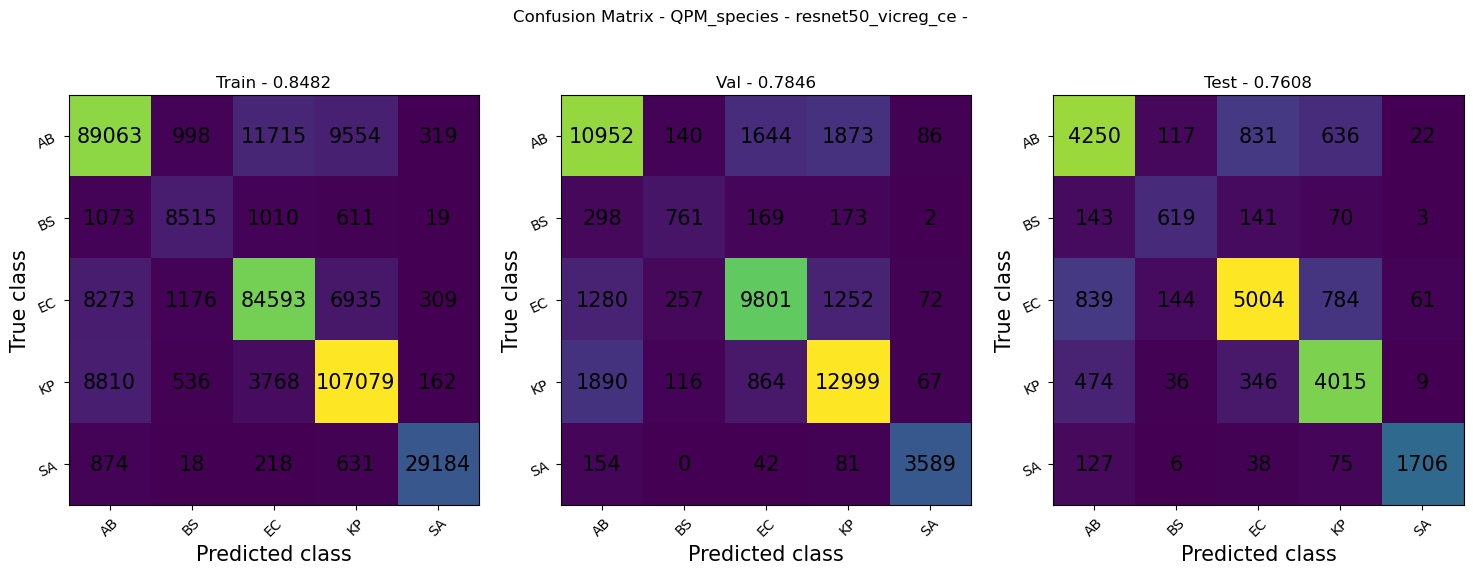

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_ftr2d = umap.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(20496, 2) (0, 2)


/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(20496, 2) (0, 2)


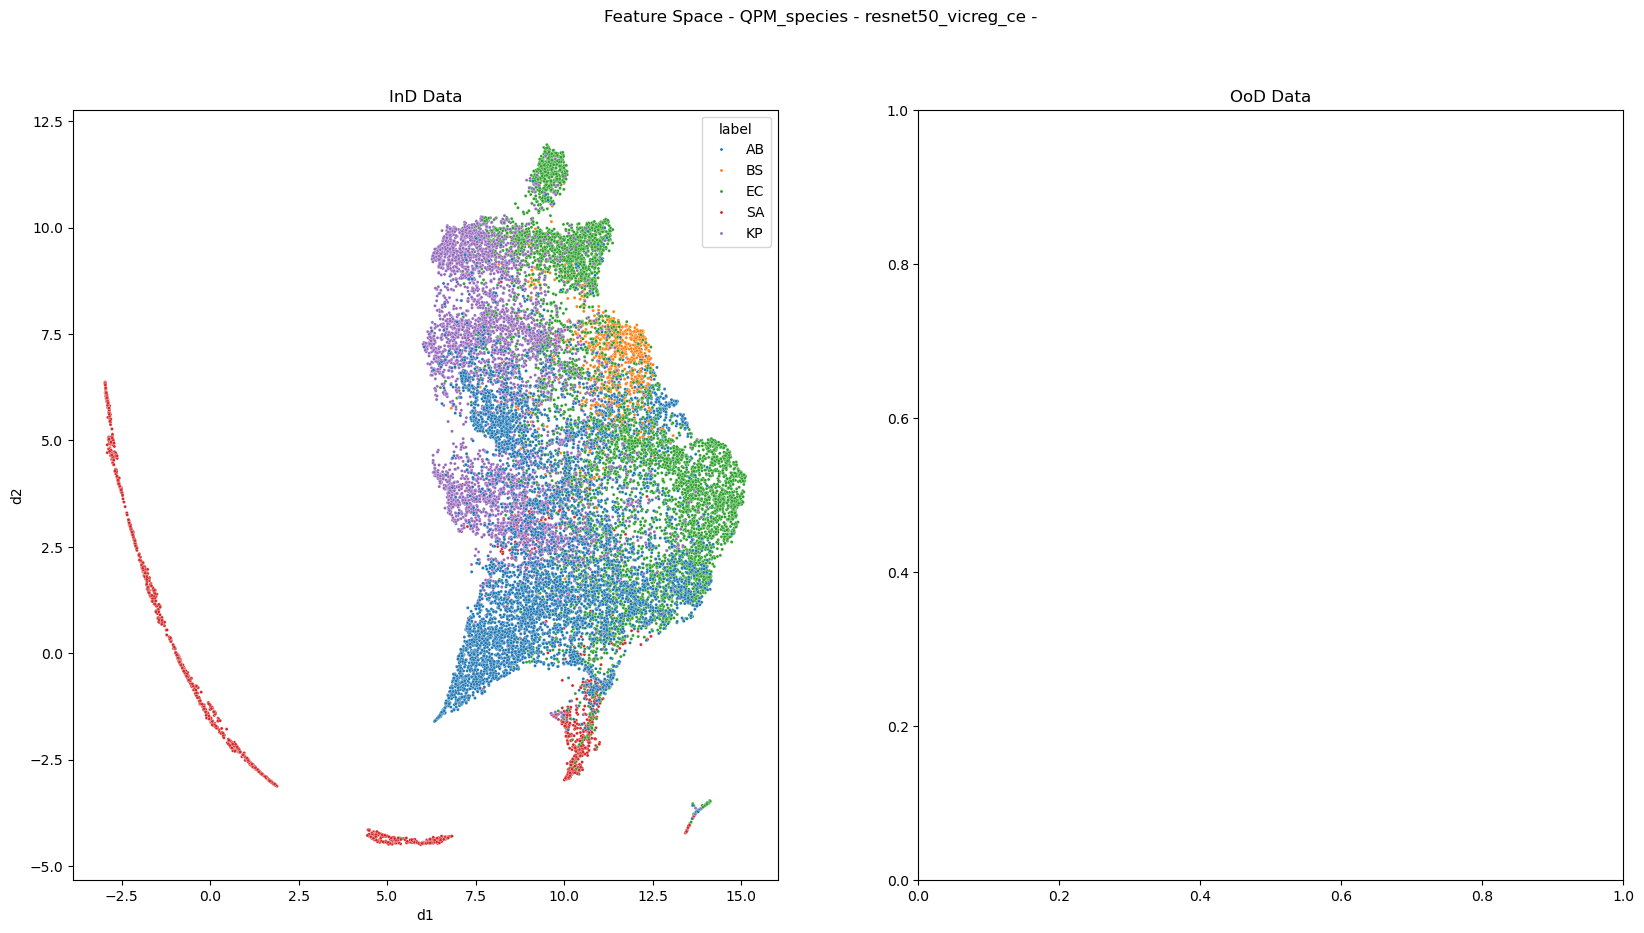

In [13]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

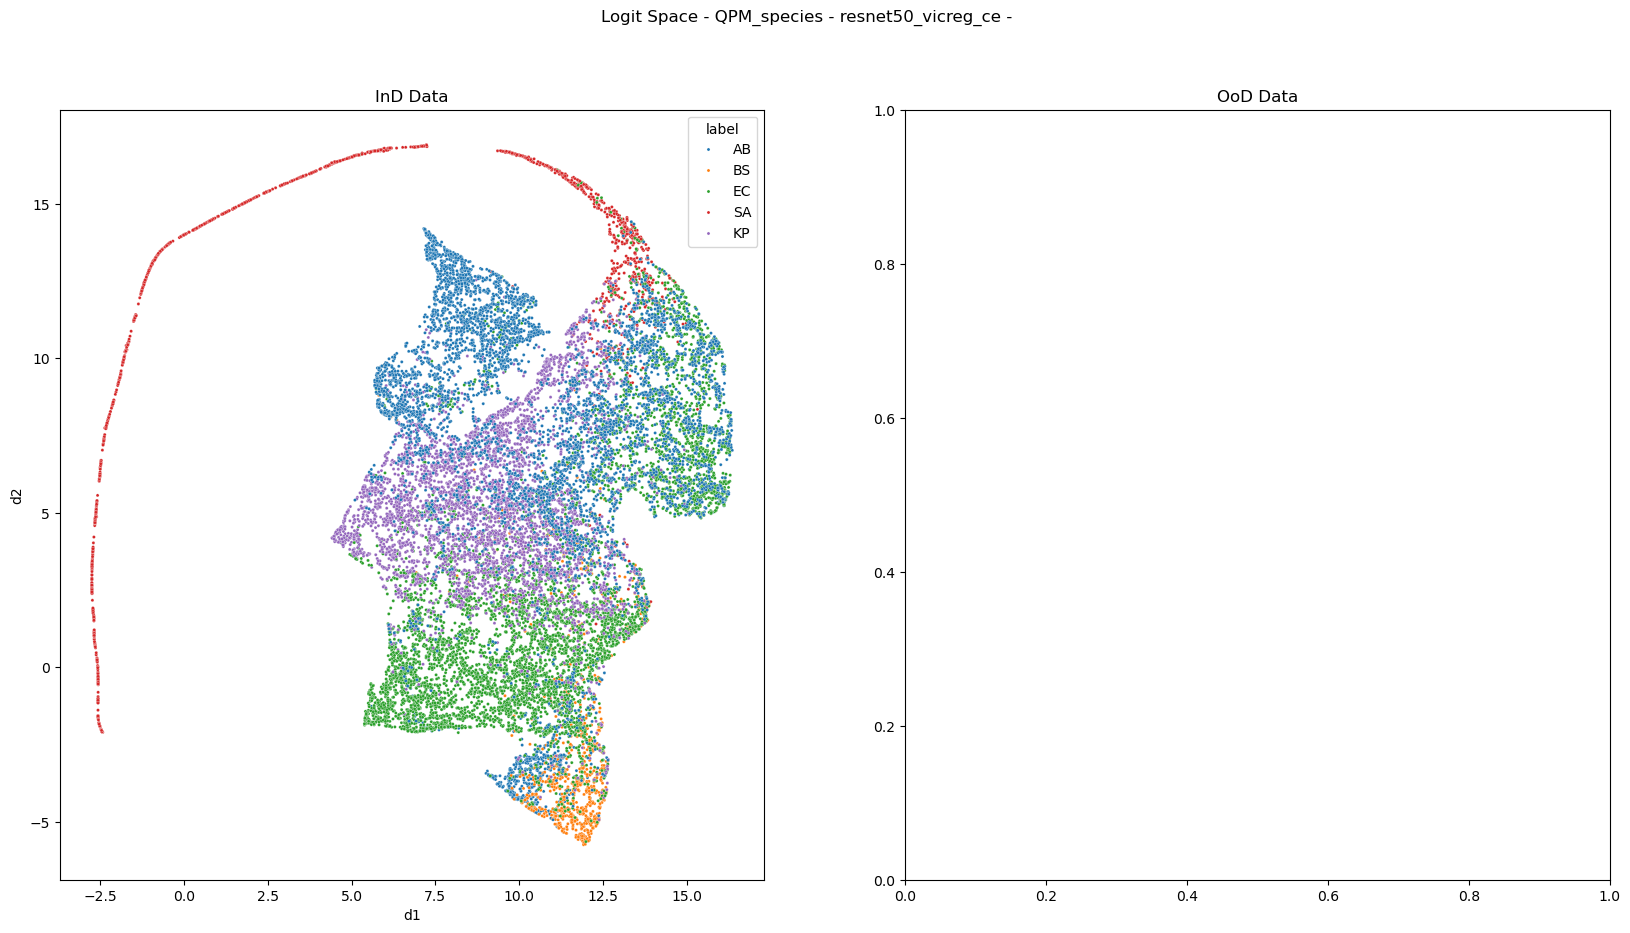

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

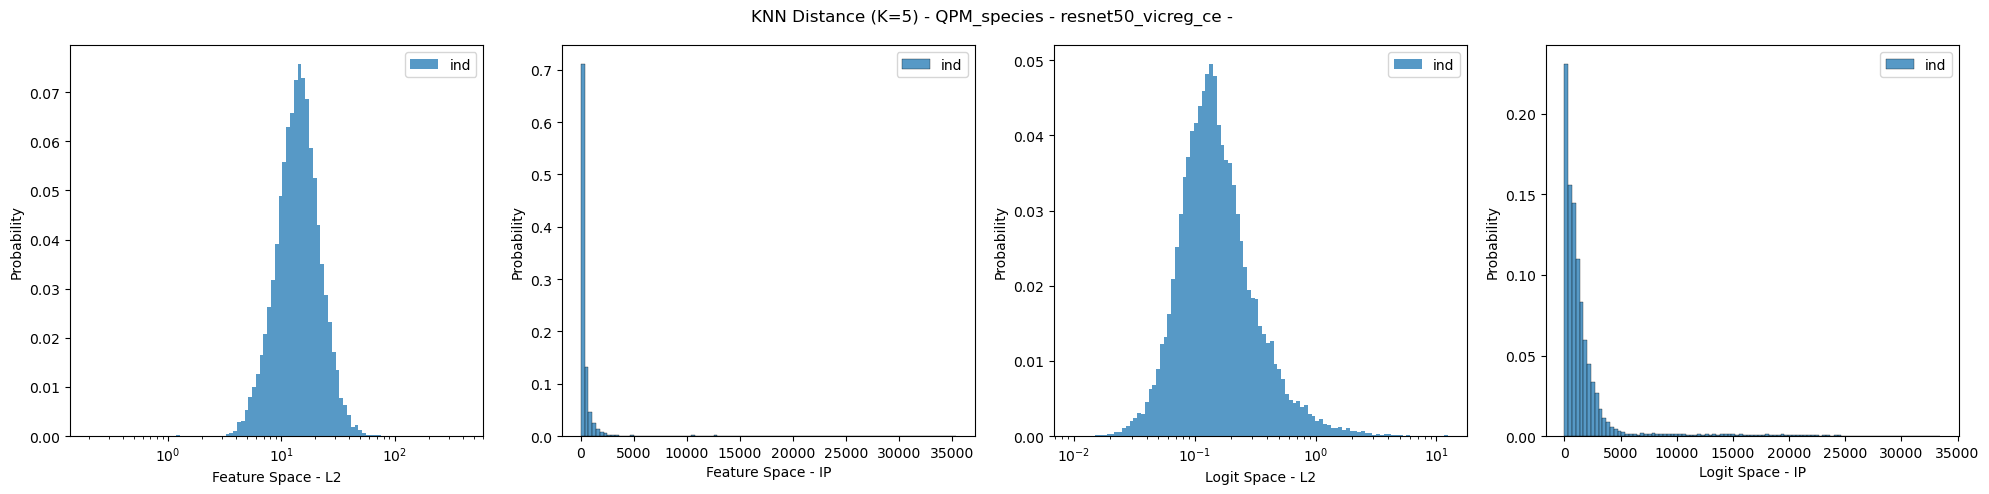

In [15]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_ftr, val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_ftr, val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

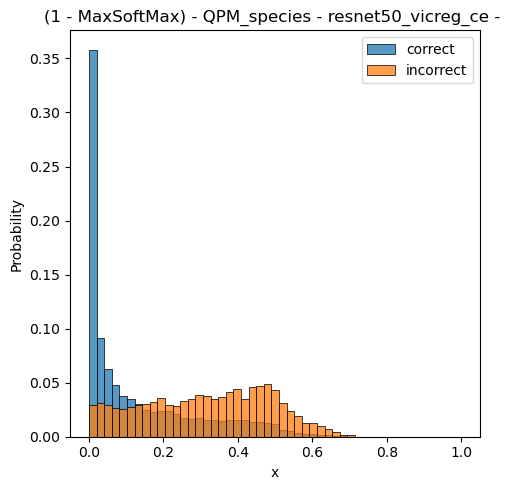

In [16]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [17]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)